## Models of Higher Brain Functions: Decision Making I
Andrey Em & Leonard Hollander

$\textbf{Exercise 1: Extended drift-diffusion model}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

#Adjusting matplotlib settings:

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams['axes.prop_cycle']= \
matplotlib.cycler(color=['firebrick', \
                         'tomato', 'coral', \
                        'steelblue','skyblue', 'silver',\
                        'gainsboro', 'whitesmoke'])

In [144]:
#Define global variables for Euler Maruyama methdod:

x0 = 0
dt = .01 #sampling rate in seconds
maxTime = 10 #simulation time in seconds
timeRange = np.arange(0,maxTime,dt)
num_sims = 5

#Define sigma, mu as time-dependent functions
sigmaFunc = lambda _,t: .5
muFunc = lambda _,t: .2
dW = lambda: np.random.normal(0,np.sqrt(dt))

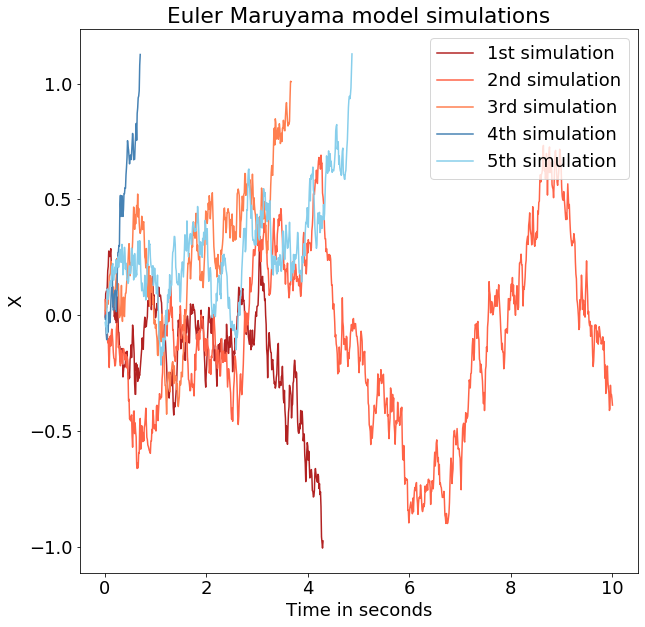

In [145]:
#Run the Euler-Maruyama method:

def eulerMaruyama(init=x0,\
                  dt=dt,\
                  num_sims=5,\
                  sim_length=maxTime,\
                  mu=muFunc,\
                  sigma=sigmaFunc,\
                  a=None):
    '''
    Runs Euler-Maruyama method to solve a stochastic differential equation,
    which is a simple form of a drift diffusion model
    @params:
    init: the initial condition of the modelled system
    dt: the sampling rate, i.e. the time step
    num_sims: the number of simulations to be run
    sim_length: the length of !one! simulation 
    There are sim_length/dt steps per simulation
    mu, sigma: drift parameters
    a: the decision criterion
    extended: Bool := are we implementing extended or simple model
    '''
    
    ys = np.zeros((num_sims, int(sim_length/dt)+1))
    ys[0] = init
    
    #Catch reaction times for part(3):
    reactionTimes = np.zeros(num_sims)
    upOrDown = np.zeros(num_sims)
    
    #Track whether a trial needs to ne resimulated
    resimulate=True
    
    i = 0
    
    while i < num_sims:
        
        for timeI, time in np.ndenumerate(timeRange):
                
            y = ys[i,timeI]
            ys[i,timeI[0]+1] = y + mu(y,time)*dt + sigma(y,time)*dW()
            
            if a==None:
                resimulate=False
                continue
            
            if a <= y:
                #Catch reaction times here:
                reactionTimes[i] = time
                upOrDown[i] = 1
                resimulate=False
                break 
            
            if y <= -a:
                reactionTimes[i] = time
                upOrDown[i] = -1
                resimulate = False
                break
                
        if resimulate:
            #resimulates trial
            continue
        
        else:
            
            i += 1
                       
    return np.where(ys==0, np.nan, ys), reactionTimes, upOrDown

#Get ordinals for pretty printing:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4])

plt.figure(figsize=(10,10))
res, times, upOrDown = eulerMaruyama(a=1)
for i in range(num_sims):
    plt.plot(np.arange(0,10+dt,dt),res[i,:], label= ordinal(i+1) + ' simulation')
    plt.title('Euler Maruyama model simulations')
    plt.xlabel('Time in seconds')
    plt.ylabel('X')
    plt.legend()
    
res=eulerMaruyama(num_sims=200, mu=muFunc)

$\textbf{Part[2]:}$

In [59]:
#Calculate the percentage of 'up' responses as a function of drift:

mu_vals = np.array([-.1,0,.1,.2,.5])
aS = np.array([2,1,.5,.25,.125])

def upPercentage(muLoc, a, num_sims):
    '''
    Plots the percentage of 'up' responses 
    (i.e. the pecentage of timesteps that lie above the decision
    criterion a)
    @params:
    mu: the drift parameter
    a: the decision criterion
    '''
    res, times, upOrDown = eulerMaruyama(num_sims=num_sims, mu=muLoc, a=a)
    perc = len(upOrDown[upOrDown==1]) / len(upOrDown)

    return perc

percentages = np.zeros((len(mu_vals), len(aS)))

for muI, mu in np.ndenumerate(mu_vals):
    
    mu_res = np.array([upPercentage((lambda _, t: mu), a, 200) for a in aS]).T
    percentages[muI,:] = mu_res

$\textbf{Part[3]:}$

In [60]:
percentages = pd.DataFrame(percentages,\
                          columns=[str(item) for item in aS])
print('The percentage "up" responses is summarized in the following table: ')
percentages.set_index(mu_vals)

The percentage "up" responses is summarized in the following table: 


,2.0,1.0,0.5,0.25,0.125
-0.1,0.100,0.310,0.425,0.395,0.525
0.0,0.240,0.445,0.555,0.485,0.540
0.1,0.370,0.690,0.575,0.520,0.480
0.2,0.615,0.820,0.790,0.595,0.580
0.5,0.965,0.990,0.855,0.740,0.680


From this we glean that the $\mu$ for which the the percentage of "up" response ($\sigma$ = 0.5) is 0.0, for which the percentage is $\approx$70%

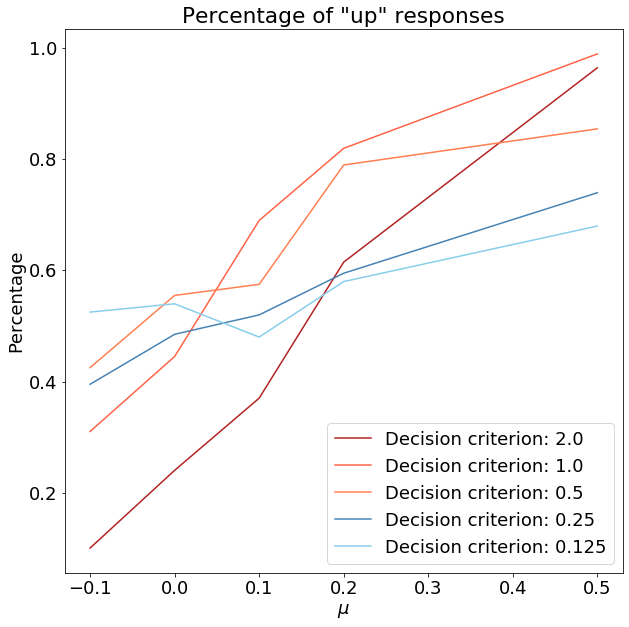

In [61]:
plt.figure(figsize=(10,10))

for col in range(percentages.values.shape[1]):
    plt.plot(mu_vals, percentages.values[:,col],\
             label='Decision criterion: ' + str(aS[col]))
    plt.title('Percentage of "up" responses')
    plt.xlabel(r'$\mu$')
    plt.ylabel('Percentage')
    plt.legend()

This is as expected. Increasing  the decision criterion should stabilize the decision making process, because it reduces the influence the noise has on the outcome (i.e. it makes it very much harder to hit the citerion just through noisy fluctuations in the signal). This is represented in the figure, e.g. in the fact that large decision criteria have greater percentages in the high values of $\mu$ and lower values in the lower values of $\mu$. By contrast, halfing the decision criterion has the opposite effect: it makes the decision far more susceptible to noise.

In [129]:
res2, times2, upOrDown2 = eulerMaruyama(num_sims=2000, \
                                        mu=lambda _,t: .1, a=1)

In [174]:
def plot_histogramms(times, upOrDown):

    fig, axs = plt.subplots(2,1, figsize=(20,10))

    fig.tight_layout(h_pad=5)

    bins = int(1/(5*dt))#Time resolution for bins: .05 seconds

    axs[0].hist(times[upOrDown==1], bins=bins, color='tomato', label = 'a=1', density=True)
    axs[0].set_title("Histogramm for up response")
    axs[0].set_xlabel("Reaction times in seconds")
    axs[0].set_ylabel("Prob density")
    axs[0].legend()



    axs[1].hist(times[upOrDown==-1], bins=bins, color='steelblue',  label= 'a=-1', density=True)
    axs[1].set_title("Histogramm for down response")
    axs[1].set_xlabel("Reaction times in seconds")
    axs[1].set_ylabel("Prob density")
    axs[1].legend()
    
    return None

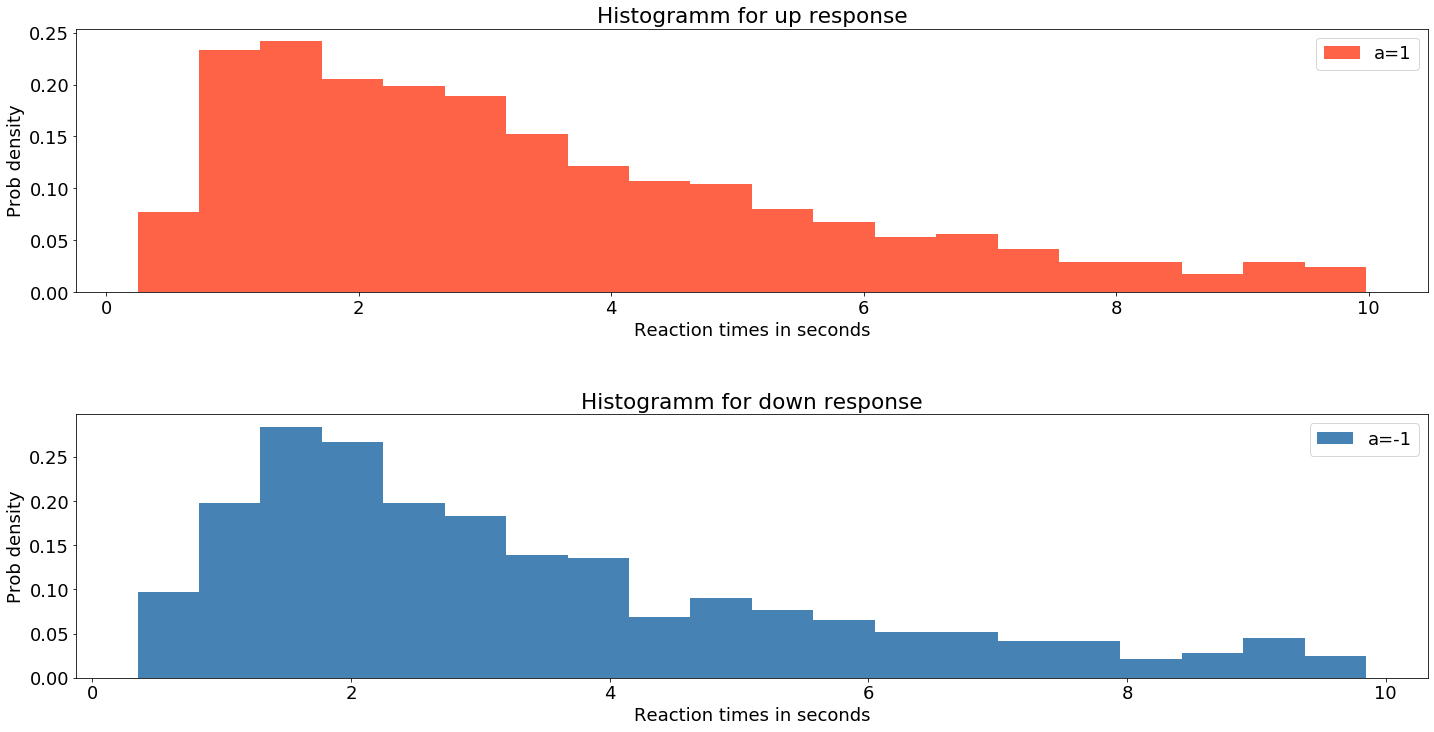

In [175]:
plot_histogramms(times2, upOrDown2)

These are as expected. They are both gamma-distribution-tyoe curves. Also, the distributions look overall pretty similar. This is confirmed, when we calculate the mean reaction times.

In [177]:
#Calculate the mean reaction:
def meanReacTimes(times, upOrDown):
    
    meanReacUp = times2[upOrDown2==1].mean()
    meanReacDown = times2[upOrDown2==-1].mean()
    print('The mean reaction time for the "up" response is: {}'.format(meanReacUp))
    print('The mean reaction time for the "down" response is: {}'.format(meanReacDown))
    
    return None

meanReacTimes(times2, upOrDown2)

The mean reaction time for the "up" response is: 3.397616822429907
The mean reaction time for the "down" response is: 3.393092105263158


The mean reaction time for the "down" response is actually slightly bigger than that of the of the "up" response. The difference between the mean reaction times is likely a statistical artefact (and, indeed, we found a lot of variation across multiple trials, but the fact never changed that they were about the same). The reason they are the same is that $\mu$ affects $\textit{which}$ decision is made, but not the $\textit{time}$ in which it is made. The bias shifts the the distribution of the noise to the right or the left (the right in this case), which makes it the case that the system will hit the upper criterion more often than the lower pne. The reaction time, however, is only affected by $\sigma$. Increasing $\sigma$ should lead to reaction times that are very much smaller, because the system can be pushed closer toward the criteria in a single simulation step.

$\textbf{Part[5]:}$

In [170]:
#These are sigmas and mus for the extended model:
muExt  = lambda _, mn, sn, t: np.random.normal(mn, np.sqrt(sn))

#Fix values for mn, sn:

MNS = np.arange(.1,1,.1)
SNS = np.linspace(0,2,5)

#Array to catch results:

percentages2 = np.zeros((len(MNS), len(SNS)))

for mnI, mn in np.ndenumerate(MNS):
    for snI, sn in np.ndenumerate(SNS):
        
        muExtPartial = lambda _, t: muExt(_, mn, sn, t)
        percentages2[mnI, snI] = upPercentage(muExtPartial, a=1, num_sims=50)
    

In [179]:
percentages2 = pd.DataFrame(percentages2,\
                          columns=[str(item) for item in SNS])
print('The percentage "up" responses is summarized in the following table: ')
percentages2.set_index(MNS)

The percentage "up" responses is summarized in the following table: 


,0.0,0.5,1.0,1.5,2.0
0.1,0.72,0.58,0.66,0.84,0.68
0.2,0.86,0.82,0.76,0.86,0.94
0.3,0.92,0.82,0.86,0.88,0.84
0.4,0.86,0.92,0.94,0.92,0.94
0.5,1.00,0.94,0.94,1.00,1.00
0.6,0.98,1.00,1.00,0.98,1.00
0.7,1.00,1.00,1.00,0.98,0.98
0.8,1.00,1.00,1.00,1.00,1.00
0.9,1.00,1.00,0.98,1.00,1.00


The first column really is irrelevant, since a Gaussian with variance 0 is just a constant, but it helps confirm that everything worked. We then pick $\mu$=.2 and $\sigma$=1, which keeps the upPercentage very close to .7. we can now use these values to run the simulations.

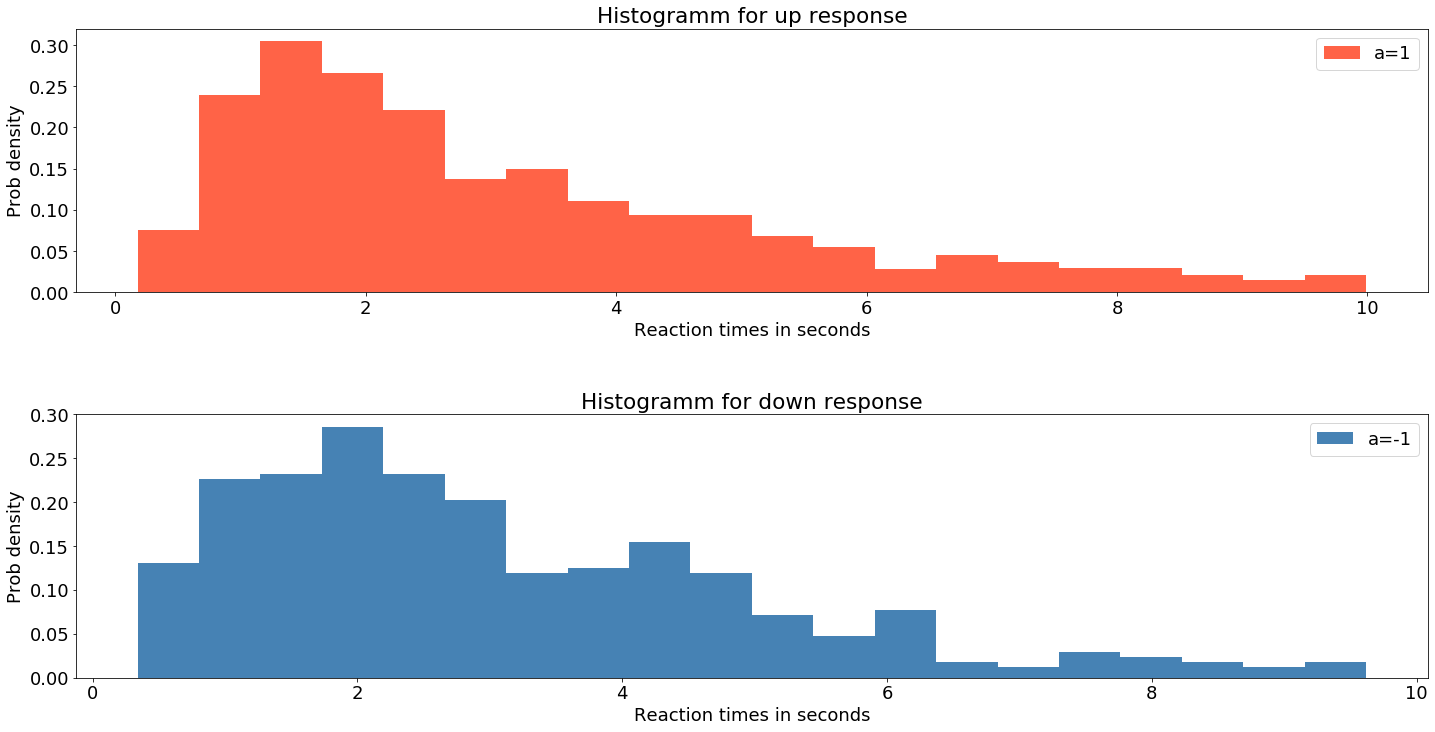

In [189]:
muExtPartial = lambda _, t: muExt(_, .2, 1, t)
res3, times3, upOrDown3 =\
    eulerMaruyama(num_sims=2000, mu=muExtPartial, a=1)

plot_histogramms(times3, upOrDown3)

In [191]:
meanReacTimes(times3, upOrDown3)

The mean reaction time for the "up" response is: 3.047530864197531
The mean reaction time for the "down" response is: 3.8927777777777783


This corresponds to more than a 25% increase in the reaction times for error trials (the values themselves are quite small because of the large $\sigma_n$). We thought this would be a good enough to demonstrate the effect. The assymetry is due to the fact that $\mu$ is now no longer simply a shift. It doesn't just affect what the mean of the system, but also how it is distributed around that mean. The reaction time is now partially a function of the probabilty of generating enough noise around that mean in order to push the system toward a decision boundary. Since $\mu$ comes from a Gaussian with positive mean $m_n$, the probability of generating enough noise is much higher for the upper decision boundary, since the probability density of the Gaussian is higher for values located closer to its mean. 